# Benchmarking the embedded fracture model against lower-dimensional interface elements

Authors: Linus Walter, Florian Zill, Thomas Nagel.

This benchmark is based on the following thesis:

*Linus Walter (2021): Hydromechanisch gekoppelte Prozesse in störungsgebundenen Tiefengrundwasserleitern -- Erstellung eines 3D Reservoirmodells in OpenGeoSys zur Auswertung von Kluftdeformationsprozessen während Bohrlochtests beim Tiefengeothermieprojekt Geretsried. Chair for Soil Mechanics and Foundation Engineering, Geotechnical Institute, TU Bergakademie Freiberg, Germany.*

on the coupled hydraulic mechanical processes in fractured aquifers used for deep geothermal.

In [161]:
#! /opt/anaconda/bin/ python3.8
import math
from ogs6py.ogs import OGS
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #für Farb en
plt.rcParams.update({'font.size': 16})

In [162]:
#Reading the OGS project files:
model_lie=OGS(INPUT_FILE="single_fracture_LIE.prj", PROJECT_FILE="single_fracture_LIE.prj")
model_efp=OGS(INPUT_FILE="single_fracture_EFP.prj", PROJECT_FILE="single_fracture_EFP.prj")
model_list=(model_lie,model_efp)

The following benchmark test is conducted as a validation of the recently created Embedded Fracture Permeability (EFP) approach being implemented by Zill (2021) in OpenGeoSys (OGS). The EFP is compared to the method of Lower-dimensional Interface Elements (LIE) which represents fractures by inlcuding them inside a continuous element mesh (Watanabe et al.,2012). Its validation with a semi-analystical solution is illustrated in Watanabe (2011).
Furthermore, the LIE modelling approach was already applied by Cacae et al. (2013) at the modeling of fracture dominated flow at the Traunreuth deep geothermal project. Consequently it is a suitable model for confirming the applicability of the EFM for fracture dominated reservoir models.

In order to create a conclusive benchmark, a simple hydro-mechanical (HM) coupled problem of a pre-existing 2D single fracture is chosen. The fracture is located symmetrically within a $\Delta\text{y}=1\,\text{m}$ wide rock matrix and has a horizontal extension of $\Delta\text{x}=25 \,\text{m}$, as to be seen in Fig.1.


<center>
<figure>
      <img src="img/01_Benchmark.jpg" alt="Benchmark" style="width:80%">
      <figcaption style="line-height:1.5;width:80%" >  
        Fig.1: Schematic geometries for fluid flow through a single fracture being conducted in the LIE and the EFP model. (Adapted from Watanabe, 2011)
     </figcaption>
</center>
</figure>


# Parametrisation

## Permeability approach

Comparing the EFP to the LIE model in Fig.1.,  the relationship of $s \gg b $ applies for the thickness of the embedded fracture zone $s$. That is because it is inconvenient to mesh tiny finite elements with an element side length of $b$.
Therefore, in order to achieve a similar pressure response within both models, an equivalent transmissibility $T$ is applied. It means that the isotropic permeability $k$ is integrated over the thickness of the homogeneous reservoir normal to the flow direction to ensure an equal mass flow $\dot m^f=\text{const.}$.

In general, both models apply the cubic law for the fracture permeability

$$
k_\text{F}=\frac{b^2}{12}
$$

Being applied at the LIE model, $T_\text{LIE}$ reads as

$$
T_\text{LIE}=k_\text{F} \, b = \frac{b^2}{12}\, b
$$

In comparison, the equivalent continuum approach in Fig.2. illustrtates, how the transmissibility $T$ derives for the EFP model in $x$-direction from

$$
  T_\text{EFP} = k \, s \qquad  \text{with} \qquad k = k_\text{M}+\frac{b}{a}\,k_\text{F}
$$

<center>
<figure>
      <img src="img/02_embedded_fracs.jpg" alt="Benchmark" style="width:80%">
       <figcaption style="line-height:1.5;width:80%" >  
        Fig.2.: In the EFP, a finite matrix element with a set of embedded fractures is parametrized by the element thickness $s$ in normal direction $y$ of the fault plane and a continuous spacing $a$. The fracture aperture is determined by $b$. (Adapted from Olivella et al., 2008, p.3)
     </figcaption>
</figure>
</center>

The total permeability $k$ of the embedded fracture zone consists of the intrinsic matrix permeability $k_\text{M}$, the ratio of $b$ and the mean fracture distance $a$ as well as the fracture permeability $k_\text{F}$. $k_\text{M}$ is assumed to be nearly impermeable for the current benchmark example. In additon, there applies $s=a$ due to the existance of only one fracture in the benchmark. The formulation of $T_\text{EFP}$ simplifies therefore to
$$
T_\text{EFP}=\frac{b^2}{12}\,b
$$


The comparison reveals that the initial apertures $b_\text{0}$ of LIE and EFP must be equal. While the initial aperture $b_\text{0}$ is a direct input parameter in LIE, $b_\text{0}$ is chosen to be applied in the EFP via the threshold strain $\epsilon_\text{0}$ regarding the relationship

$$
b(t=0)=b_\text{0} + a \, \langle \epsilon_\text{n}-\epsilon_\text{0} \rangle
$$
The normal strain $\epsilon_\text{n}$ and the initial aperture $b_\text{0}$ are assumed to be zero at the initial stage. Hence, the aperture at the initial stage is implemented as

$$
\epsilon_\text{0}= -\frac{b(t=0)}{a}
$$

The respective parameters are defined and implemented as follows:

In [163]:
k_m = 1e-21  #intrinsic permeability
b   = 1e-5   #aperture at t=0
b0  = 0      #initial aperture
a   = 1e-3   #Mean fracture distance
e0  = -b/a   #Threshold strain

#Applying parameters
#LIE
model_lie.replace_parameter_value(name="k",value=k_m)
model_lie.replace_parameter_value(name="b",value=b)
#EFP
model_efp.replace_parameter_value(name="k",   value=b0**2/12)
model_efp.replace_text('%.2e %.2e %.2e' %(a, a, a), xpath="./media/medium/properties/property[name='permeability']/mean_frac_distances")
model_efp.replace_text('%.2e %.2e %.2e' %(-e0, e0, -e0), xpath="./media/medium/properties/property[name='permeability']/threshold_strains")

print(' b=  %.2e for t=0 \n a=  %.2e \n e0=%.2e   '%(b,a,e0))

model_efp.write_input()
model_lie.write_input()

 b=  1.00e-05 for t=0 
 a=  1.00e-03 
 e0=-1.00e-02   


True

## Storage and Compressibility

In the EFP modelling approach, the storage term is calculated via the input parameters fluid compressibility $\kappa^\mathrm{f}_\text{R}$ and the real compressibility of the solid $\kappa^\mathrm{s}_\text{R}$. <br>
$\kappa^\mathrm{f}_\text{R}$ is implemented via the pressure dependent fluid density

$$
\rho^\mathrm{f}_\text{R} (p^\mathrm{f})= \rho^\mathrm{f}_\text{ref} \left ( 1 +  \kappa^\mathrm{f}_\text{R} \left (  p^\mathrm{f}_\text{R} - p^\mathrm{f}_\text{ref} \right ) \right )
$$


Furthermore, $\kappa^\mathrm{s}_\text{R}$ is calculated via the Biot-Willis coefficient $\alpha_\text{B}$, the drained bulk modulus of the grain skeleton $K^\mathrm{s}$, Young's modulus of the matrix $E_\text{M}$ and Poisson's ratio $\nu$ 

$$
\kappa^\mathrm{s}_\text{R} = \frac{1-\alpha_\text{B}}{K^\mathrm{s}}  \qquad \text{where} \qquad K^\mathrm{s} = \frac{E_\text{M}}{3 \, (1-2\,\nu)} \qquad \text{applies.}
$$

On the other hand, the LIE model uses the specific storage $S_\text{s}$ as input parameter which is calculated from 

$$
S_\text{s} = \left (  \left (  \alpha_\text{B} - \phi  \right ) \, \kappa^\mathrm{s}_\text{R} + \phi \, \kappa^\mathrm{f}_\text{R} \right )
$$

where $\phi$ is the porosity of the porous medium. The fluid viscosity $\mu^\mathrm{f}$ is implemented as a constant parameter in both models,.

<br>

## Equivalent joint normal stiffness

The LIE model uses the joint normal stiffness $K_\text{n}$ and the joint shear stiffness $K_\text{s}$ as elastic parameters for dertermining the mechanical fracture behaviour. For the EFP, $K_\text{n}$ is implemented via an equivalent Young's modulus $E_\text{RM}$ for the embedded fracture zone as being derived by Gerrard (1982):

$$
 \frac{1}{E_\text{RM}}=\frac{1}{E_\text{M}}+\frac{1}{K_\text{n}\,a}
$$

The joint shear stiffness $K_\text{s}$ is not considered in the present benchmark.

In [164]:
###
### Material Parametrisation
###

#Fluid
rho_fr      = 1e3 
kappa_fr    = 1e-7
mu_f        = 1e-3 #Pa s

#Solid parameters
rho_sr      = 2.716e3 #kg/m³
a_b         = 1   #Biot-Willis
E           = 60e9
nu          = 0
poro_matrix = 0.001

#Fracture properties
poro_frac   = poro_matrix # 1e-5
Kn	        = 1e11
Ks	        = 1e11

###
### Calculation
###

# Calc Storage Porous Medium LIE:
K_S = E / (3*(1-2*nu))
kappa_sr = (1.0 - a_b) / K_S
S_matrix = ((a_b - poro_matrix) * kappa_sr + poro_matrix * kappa_fr)

#Calc Storage Fracture LIE
S_f = ((a_b - poro_frac) * kappa_sr + poro_frac * kappa_fr)

#Calc Equiv. Young's Modulus EFP
E_rm = (1/E + 1/a/Kn)**(-1)

print("\
kappa_sr = %f \n\
S_matrix = %.2e \n\
     S_f = %.2e \n\
    E_rm = %.2e"%(kappa_sr,S_matrix,S_f,E_rm))

###
### Applying Parameters
###

# Replace Parameters in LIE
model_lie.replace_parameter_value(name="rho_fr",   value=rho_fr)
model_lie.replace_parameter_value(name="mu",       value=mu_f)
model_lie.replace_parameter_value(name="rho_sr",   value=rho_sr)
model_lie.replace_parameter_value(name="phi",      value=poro_matrix)
model_lie.replace_parameter_value(name="biot_m",   value=a_b)
model_lie.replace_parameter_value(name="E",        value="%.2e"%E)
model_lie.replace_parameter_value(name="nu",       value=nu)
model_lie.replace_parameter_value(name="S",value="%.2e"%S_matrix)
#Fracture
model_lie.replace_parameter_value(name="S_f",value="%.2e"%S_f)
model_lie.replace_parameter_value(name="biot_f",value=a_b)
model_lie.replace_parameter_value(name="Kn",value="%.2e"%Kn)
model_lie.replace_parameter_value(name="Ks",value="%.2e"%Ks)

# Replace Parameters in EFP
model_efp.replace_text(rho_fr, xpath="./media/medium/phases/phase[type='Gas']/properties/property[name='density']/reference_value")
model_efp.replace_text(kappa_fr, xpath=("./media/medium/phases/phase[type='Gas']/properties/property[name='density']/independent_variable/slope"))

for id in (0,1):
    model_efp.replace_phase_property_value(mediumid=id,phase="Gas", name="viscosity",value=mu_f)
    model_efp.replace_phase_property_value(mediumid=id,phase="Solid", name="density",value=rho_sr)
    model_efp.replace_medium_property_value(mediumid=id,name="biot_coefficient",value=a_b)
model_efp.replace_medium_property_value(mediumid=0, name="porosity",value=poro_matrix)
model_efp.replace_medium_property_value(mediumid=1, name="porosity",value=poro_frac)
model_efp.replace_text("%.2e"%E, xpath="./parameters/parameter[name='E']/indexvalues[index='0']/value")
model_efp.replace_text("%.2e"%E_rm, xpath="./parameters/parameter[name='E']/indexvalues[index='1']/value")
model_efp.replace_parameter_value(name="nu",value=nu)

model_efp.write_input()
model_lie.write_input()

kappa_sr = 0.000000 
S_matrix = 1.00e-10 
     S_f = 1.00e-10 
    E_rm = 9.98e+07


True

<br>

## Overview Material parametrisation

| Material |                          LIE Model 			   ||            EFP Model       |                                                              |
| -------: | ---------------------------------: | ------------ | -------------------------: | :------------------------------------------------------------ |
| **Fluid** | Density $\rho^\mathrm{f}_\text{R}$ | 1 000 kg m⁻³ |  | $\rho^\mathrm{f}_\text{R}$ = $\rho^\mathrm{f}_\text{R,0}\,(1+\kappa^\mathrm{f}_\text{R})$ <p style="margin-left: 40px"> with $\rho^\mathrm{f}_\text{R,0}$ = 1000 kg m⁻³ <br/> and $\kappa^\mathrm{f}_\text{R} $ = $1\times 10^{-7}$ Pa⁻¹ <p> |
|          |         Viscosity $\mu^\mathrm{f}$ | 0.1 mPa s    |           $\mu^\mathrm{f}$ |       0.1 mPa s                                                       |
|  <br>        |                                    |              |                            |                                                              |
| **Matrix** | Density $\rho^\mathrm{s}_\text{R}$ | 2 716 kg m⁻³ | $\rho^\mathrm{s}_\text{R}$ | 2 716 kg m⁻³ |
|          | Spec. Storage $S_\text{S}$ | 1$\,\times\,$10⁻¹⁰ Pa |  | considered via $\kappa^\mathrm{f}_\text{R}$ |
|          | Biot-Willis $\alpha_\text{B}$ | 1 | $\alpha_\text{B}$ | 1 |
|          | Matrix permeability $k_\text{M}$ | 1$\,\times\,$10⁻²¹ m² | $k_\text{M}$ | 1$\,\times\,$10⁻²¹ m² |
|          | Porosity $\phi$ | 1$\,\times\,$10⁻³ | $\phi$ | 1$\,\times\,$10⁻³ |
|          | Young’s modulus $E_\text{M}$ | 60$\,\times\,$10⁶ Pa | $E_\text{M}$ | 60$\,\times\,$10⁶ Pa |
|          | Poisson’s ratio $\nu$ | 0 | $\nu$ | 0 |
|    <br>      |                                    |              |                            |                                                              |
| **Fracture** | Initial aperture $b_\text{0}$ | 1$\,\times\,$10⁻⁵ | $b_\text{0}$ | 1$\,\times\,$10⁻⁵ |
|          | Mean frac dist $a$ | n.a. | $a$ | 1$\,\times\,$10⁻³ m |
|          | Threshold strain $\epsilon_\text{0}$ | n.a. | $\epsilon_\text{0}$ | -1$\,\times\,$10⁻² |
|          | Spec. Storage $S_\text{S}$ | 1$\,\times\,$10⁻¹² |                            | considered via  $\kappa^\mathrm{f}_\text{R}$ and $\phi$|
|          | Biot-Willis $\alpha_\text{B}$ | 1                   |          $\alpha_\text{B}$ | 1 |
|          | Joint norm. stiffn. $K_\text{n}$ | 1$\,\times\,$10¹¹ Pa | $K_\text{n}$ | considered via euqiv. Young’s modulus <br> $E_\text{RM}$ = 9.89$\,\times\,$10⁷ Pa |
|      | Joint sear stiffn. $K_\text{s}$ | 1$\,\times\,$10¹¹ Pa |      | n.a. |

## Initial conditions and boundary conditions

The initial setup has a displacement of $u_\text{0} = 0$ in all directions for both models. Regarding the fluid pressure, the LIE model is subjected to an initial fluid pressure of $ p^\text{f}_\mathrm{R,0} = 11.0\,\times\,10⁶ \,\text{Pa}$. Furthermore, a uniform line load of $\sigma_{yy}=-50 \,\times\,10⁶ \,\text{Pa}$ is applied on its top boundary what results in an effective stress of $\sigma_{E,yy}=-39\,\times\,10⁶ \,\text{Pa}$ in $y$-direction. On the contrary, the EFP model is calculated with relative stress values which leads to a parametrisation of $ p^\text{f}_\mathrm{R,0} = 0 \,\text {Pa}$ and $\sigma_{yy}=0 \,\text{Pa}$ at the initial stage.

In addition, a hydraulic flow rate is applied at the inlet. For the LIE, the flow rate is applied as a volumetric flow rate $\dot Q^\mathrm{f}= \dot m^\mathrm{f} / \rho^\mathrm{f}_\text{R}$ on the fracture inlet while it is applied as a mass flow rate $\dot m^\mathrm{f}$ per boundary length $s$ in the EFP model.

At $ t=1000 \,\text{s} $, the hydraulic flow is reversed which changes the flow regime from injection to production. 

In [165]:
###
### Pressure and Discplacement
###

#IC and BC conditions LIE
p0_lie            = 1.1e7
u0_lie            = "0 0"
sigma_yy_lie      = -5.00e+07
sigma0_E_yy_lie   = "0 %.2e 0 0"%(sigma_yy_lie+p0_lie)
sigma0_E_frac_lie = "0 %.2e"%(sigma_yy_lie+p0_lie)

#IC and BC conditions EFP
p0_efp            = 0
u0_efp            = u0_lie
sigma_yy_efp      = 0
sigma0_E_yy_efp   = "0 %.2e 0 0"%(sigma_yy_efp+p0_efp)

###
### Hydraulic Flow BC
###

#Time coordinates
coords = "0 100 1000 1100 2000"

m_f = 3e-5
area_parameter = 1  #1 since injection happens via a point which has no integration length

q_f = m_f /rho_fr
values_lie = "%.2e %.2e %.2e %.2e %.2e"%(0, q_f,q_f,-q_f,-q_f)
value_efp = m_f/a
values_efp = "%.2e %.2e %.2e %.2e %.2e"%(0, value_efp,value_efp,-value_efp,-value_efp)

###
### Applying Parameters
###

#LIE
model_lie.replace_text(u0_lie, xpath="./parameters/parameter[name='displacement0']/values")
model_lie.replace_parameter_value(name="p0",value="%.2e"%p0_lie)
model_lie.replace_parameter_value(name="load",value="%.2e"%sigma_yy_lie)
model_lie.replace_text(sigma0_E_yy_lie, xpath="./parameters/parameter[name='effective_stress0']/values")
model_lie.replace_text(sigma0_E_frac_lie, xpath="./parameters/parameter[name='fracture_effective_stress0']/values")

#EFP
model_efp.replace_text(u0_efp, xpath="./parameters/parameter[name='displacement0']/values")
model_efp.replace_parameter_value(name="p0",value="%.2e"%p0_efp)
model_efp.replace_parameter_value(name="load",value="%.2e"%sigma_yy_efp)
model_efp.replace_text(sigma0_E_yy_efp, xpath="./parameters/parameter[name='effective_stress0']/values")

#LIE and EFP
for model,values in zip(model_list,(values_lie,values_efp)):
    model.replace_text(coords, xpath="./curves/curve[name='curve_q_in']/coords")
    model.replace_text(values, xpath="./curves/curve[name='curve_q_in']/values")
    model.write_input()

print("Time coordinates: "+coords)
print("Curve Values EFP: "+values_lie)
print("Curve Values LIE: "+values_efp)

model_efp.write_input()
model_lie.write_input()

Time coordinates: 0 100 1000 1100 2000
Curve Values EFP: 0.00e+00 3.00e-08 3.00e-08 -3.00e-08 -3.00e-08
Curve Values LIE: 0.00e+00 3.00e-02 3.00e-02 -3.00e-02 -3.00e-02


True

## Time Stepping
The total test length `t_end` is supposed to be $t=2000 \text{s}$. Depending on the step length `delta_t`, the amount of steps `repeat` is calculated.

In [166]:
# Length of the 
t_end   = 2000
delta_t = 10
repeat  = "%i"%(t_end/delta_t)

for model in model_list:
    model.replace_text(t_end,xpath="./time_loop/processes/process/time_stepping[type='FixedTimeStepping']/t_end")
    model.replace_text(repeat,xpath="./time_loop/processes/process/time_stepping[type='FixedTimeStepping']/timesteps/pair/repeat")
    model.replace_text(delta_t,xpath="./time_loop/processes/process/time_stepping[type='FixedTimeStepping']/timesteps/pair/delta_t")

model_efp.write_input()
model_lie.write_input()

True

# Run Models
Please enter your local OGS build-path at `PATH_OGS`. The output of OGS can be found in the `out`-file in the current directory.


In [167]:
PATH_OGS="/home/mok/ogs_release/bin/"
model_lie.run_model(path=PATH_OGS)

OGS finished with project file single_fracture_LIE.prj.
Execution took 20.37191367149353 s


In [168]:
model_efp.run_model(path=PATH_OGS)

OGS finished with project file single_fracture_EFP.prj.
Execution took 86.49432897567749 s


# Postprocessing

In [169]:
import vtuIO
pvd_efp = vtuIO.PVDIO("single_fracture_EFP.pvd", dim=2)
pvd_lie = vtuIO.PVDIO("single_fracture_LIE_.pvd", dim=2)

slight changes of interpolated values if defaults are/were used.
slight changes of interpolated values if defaults are/were used.


## Plot Point Data over Time

In [170]:
#Punktauswahl:
#points = {"pt_IN": (0,0.5,0), "pt_OUT": (25,0.5,0)}
pt_in = {"pt0": (0.0,0.5,0.0)}
pt_out = {"pt25": (25.0,0.5,0.0)}

# Ergebnisdatasets:
results_efp_in  = {}
results_efp_out = {}
results_lie_in  = {}
results_lie_out = {}

In [172]:
pvd_efp.read_time_series("pressure_interpolated",pts=pt_in,interpolation_method='nearest');

In [173]:
results_efp_in["pressure_interpolated"]=pvd_efp.read_time_series("pressure_interpolated",pts=pt_in,interpolation_method='nearest')
results_efp_out["pressure_interpolated"]=pvd_efp.read_time_series("pressure_interpolated",pts=pt_out,interpolation_method='nearest')

results_lie_in["pressure_interpolated"]=pvd_lie.read_time_series("pressure_interpolated",pts=pt_in,interpolation_method='nearest')  
results_lie_out["pressure_interpolated"]=pvd_lie.read_time_series("pressure_interpolated",pts=pt_out,interpolation_method='nearest')

''

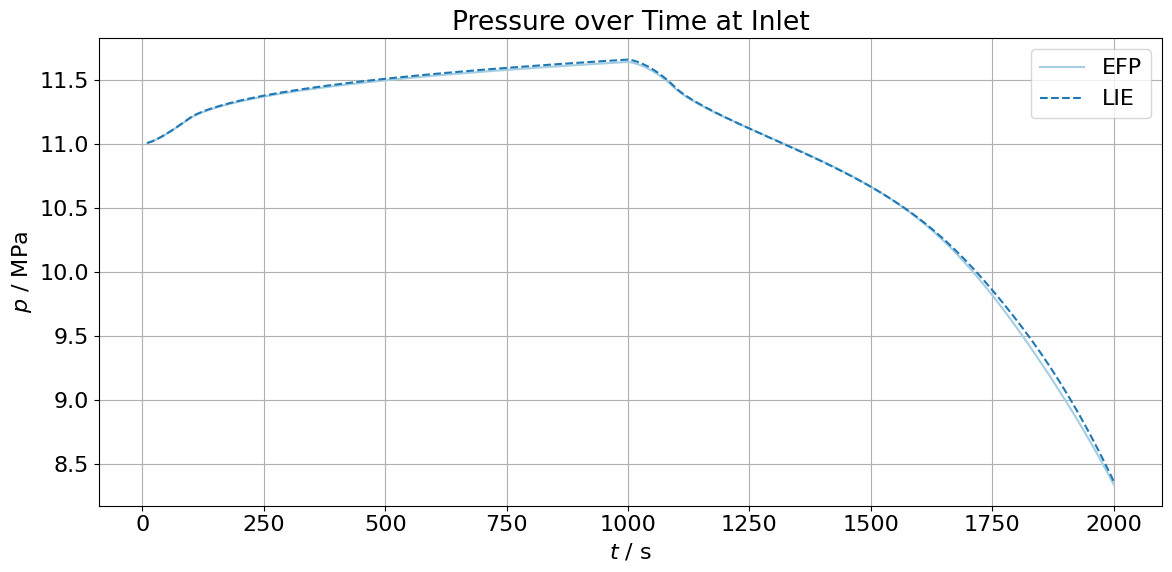

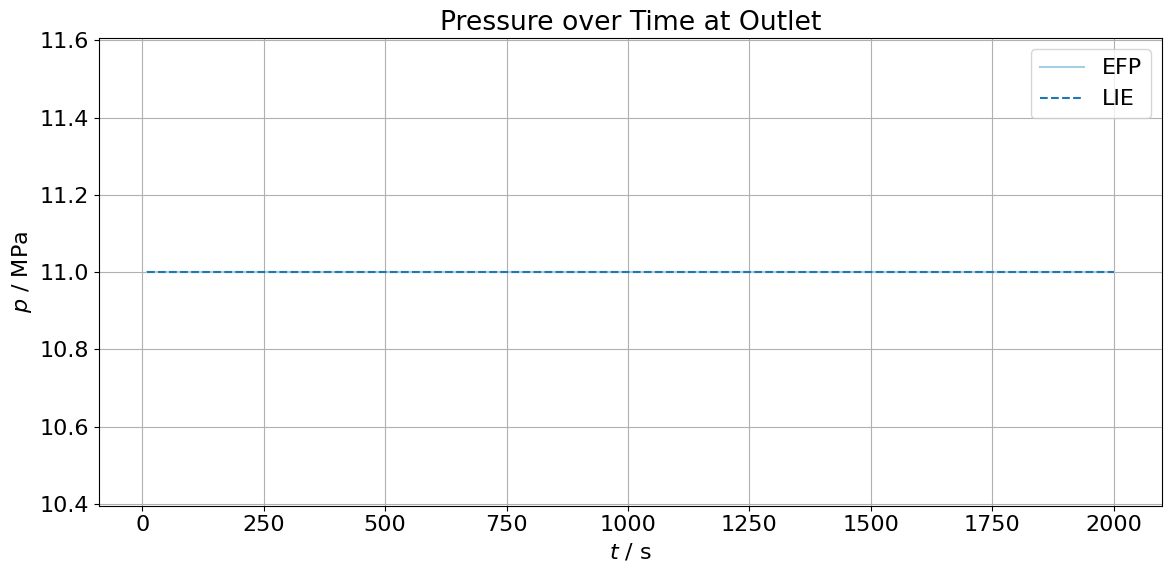

In [176]:
lie_points=(results_lie_in['pressure_interpolated']['pt0'],results_lie_out['pressure_interpolated']['pt25'])
efp_points=(results_efp_in['pressure_interpolated']['pt0'],results_efp_out['pressure_interpolated']['pt25'])
Title=('Pressure over Time at Inlet','Pressure over Time at Outlet')
Figname=('Pressure_over_time_p0.png','Pressure_over_time_p25.png')

for efp_points,lie_points,title,figname in zip(efp_points,lie_points,Title,Figname):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(pvd_efp.timesteps[1:],(efp_points+p0_lie)[1:]/1e6,label='EFP')
    ax.plot(pvd_lie.timesteps[1:],(lie_points)[1:]/1e6,label='LIE', ls='--')
    ax.set_xlabel('$t$ / s')
    ax.set_ylabel('$p$ / MPa')
    plt.title(title)
    ax.legend()
    # plt.ylim(1.1e7,1.15e7)
    plt.grid()
    fig.tight_layout()
    plt.show
    #plt.savefig(figname,dpi=300)
;

The pressure evolution during injection and production is captured by both models. Also, the influence of fracture opening and closure is correctly reproduced.

## Plot Data over Line

''

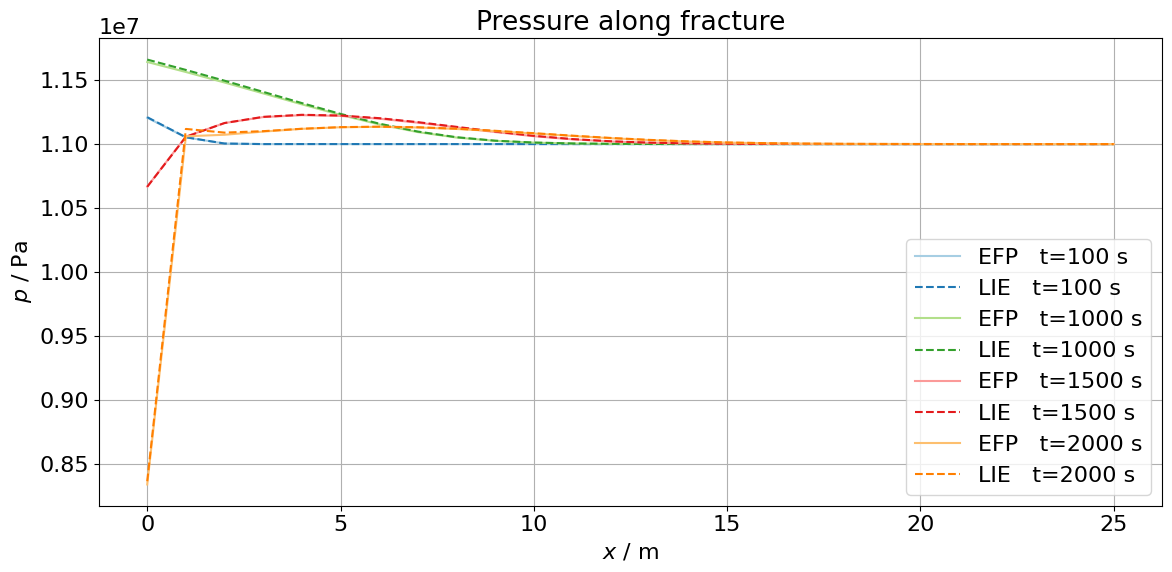

In [186]:
sns.set_palette("Paired",n_colors=10)
fig, ax = plt.subplots(figsize=(12,6))
#Define Axis
line_x_efp=[(i,0.5,0) for i in np.linspace(start=0.0, stop=25.0, num=51)]
line_x_lie=[(i,0.5,0) for i in np.linspace(start=0.0, stop=25.0, num=51)]
# Achse konvertieren zu geraden Zahlen:
r_x = np.array(line_x_efp)[:,0]
# print(r_x)
#Timestep
timesteps = [100,1000,1500,2000] #

for t in timesteps:
    results_efp_line = pvd_efp.read_set_data(t,'pressure_interpolated', pointsetarray=line_x_efp)
    ax.plot(r_x,(results_efp_line+p0_lie)/1e6 ,label='EFP   t=%i s'%t, ls='-')
    results_lie_line = pvd_lie.read_set_data(t,'pressure_interpolated', pointsetarray=line_x_lie)
    ax.plot(r_x,results_lie_line / 1e6 ,label='LIE   t=%i s'%t, ls='--')

plt.title('Pressure along fracture')
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$p$ / MPa')
ax.legend(loc='best')
# plt.ylim(0.9e7,1.22e7)
plt.grid()
fig.tight_layout()
plt.show
#plt.savefig('Pressure_over_x_axis.png',dpi=300)
;

The spatial profiles captured by both models are also equivalent.

## References:
Cacace, M., Blöcher, G., Watanabe, N., Moeck, I., Börsing, N., Scheck-Wenderoth, M., Kolditz, O., & Huenges, E. (2013). Modelling of fractured carbonate reservoirs: Outline of a novel technique via a case study from the Molasse Basin, southern Bavaria, Germany. Environmental Earth Sciences, 70(8), 3585–3602. https://doi.org/10.1007/s12665-013-2402-3

Gerrard, C. M. (1982). Elastic models of rock masses having one, two and three sets of joints. International Journal of Rock Mechanics and Mining Sciences And, 19(1), 15–23. https://doi.org/10.1016/0148-9062(82)90706-9

Watanabe, N., Wang, W., Taron, J., Görke, U. J., & Kolditz, O. (2012). Lower-dimensional interface elements with local enrichment: application to coupled hydro-mechanical problems in discretely fractured porous media. International Journal for Numerical Methods in Engineering, February, 1010–1034. https://doi.org/10.1002/nme.3353

Watanabe, N. (2011). Hydromechanics with a fracture. https://www.opengeosys.org/docs/benchmarks/hydro-mechanics/LIE_HM.pdf

Zill, F., Nest, M., Kolditz, O., & Nagel, T. (2021). Hydro-mechanical continuum modelling of hydrogen percolation through rock salt. In review.